In [1]:
import sys
sys.path.append("/home/risitop/Documents/PHD/vc_project/")
import scripts as vc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import time
import itertools
from sklearn.metrics import homogeneity_score
from pynndescent import NNDescent
from numba import njit

# Plotting

In [2]:
# Plotting parameters

dotsize = 10
qcolor = 'royalblue' # query
qmarker = 's'
rcolor = 'crimson' # reference
rmarker = 'o'
icolor = 'yellow' # integrated
imarker = 'D'
x_label = 'PC1'
y_label = 'PC2'
titlesize = 15
labelsize = 15
legendsize = 10

# Plotting function

def plot_datasets(*datasets,
                   title=None,
                   x_label=None,
                   y_label=None,
                   enable_cbar=False,
                   cbar_title=None,
                   **kwargs):
    for dataset in datasets:
        X = dataset['X']
        color = dataset['c']
        kwargs_to_pass = {k: dataset[k] for k in dataset if k not in ('X', 'c')}
        plt.scatter(*X.T, c=color, **kwargs_to_pass, **kwargs)
    if x_label is not None:
        plt.xlabel(x_label, size=labelsize)
    if y_label is not None:
        plt.ylabel(y_label, size=labelsize)
    if any("label" in dataset for dataset in datasets):
        plt.legend(fontsize=legendsize)
    plt.xticks([])
    plt.yticks([])

    if enable_cbar:
        cbar = plt.colorbar()
        if cbar_title is not None:
            cbar.ax.set_ylabel(cbar_title, fontsize=labelsize)

    if title is not None:
        plt.title(title, fontsize=titlesize)

# Generating datasets

In [3]:
n_clusters = [6]
n_samples_per_cluster = [100, 500, 1000, 5000, 10000, 50000, 100000]
n_hops = [1, 2, 3]
dimensions = [10]

parameters_combinations = [
    (nc, ns, d, nh) 
    for nc in n_clusters
    for ns in n_samples_per_cluster
    for d in dimensions
    for nh in n_hops
]

results = {}
for nc, ns, d, nh in parameters_combinations:
    
    print(f'n_samples: {ns*nc} / n_clusters: {nc} / dim: {d} / hops: {nh}')
    
    # Initialization
    dct_results = {
        'n_samples': ns*nc,
        'n_clusters': nc,
        'dimension': d,
        'n_hops': nh
    }
    X, labels = make_blobs(
        n_samples=ns*nc,
        n_features=d,
        centers=nc
    )
    X_pca = PCA(n_components=2).fit_transform(X)
    
    # VC
    tic = time.time()
    anchors, mapping = vc.vertex_cover(X, n_neighbors=15, hops=nh)
    dct_results['time_vc'] = time.time() - tic
    dct_results['n_anchors'] = np.sum(anchors).astype(int)
    
    # Clustering
    tic = time.time()
    km = KMeans(n_clusters=nc)
    assignment = km.fit(X).labels_
    dct_results['time_kmeans'] = time.time() - tic
    
    # Clustering+VC
    tic = time.time()
    km = KMeans(n_clusters=nc)
    assignment_vc = km.fit(X[anchors==1]).labels_
    dct_results['time_kmeans_vc'] = time.time() - tic
    
    small_idx = np.array([ # i -> anchor of i mapping
    np.sum(anchors[:mapping[i]]).astype(int)
        for i in range(len(X))
    ])
    
    dct_results['labels'] = labels
    dct_results['assignment'] = assignment
    dct_results['assignment_vc'] = assignment_vc[small_idx]
    
    results[(nc, ns, d, nh)] = dct_results

n_samples: 600 / n_clusters: 6 / dim: 10 / hops: 1
n_samples: 600 / n_clusters: 6 / dim: 10 / hops: 2
n_samples: 600 / n_clusters: 6 / dim: 10 / hops: 3
n_samples: 3000 / n_clusters: 6 / dim: 10 / hops: 1
n_samples: 3000 / n_clusters: 6 / dim: 10 / hops: 2
n_samples: 3000 / n_clusters: 6 / dim: 10 / hops: 3
n_samples: 6000 / n_clusters: 6 / dim: 10 / hops: 1
n_samples: 6000 / n_clusters: 6 / dim: 10 / hops: 2
n_samples: 6000 / n_clusters: 6 / dim: 10 / hops: 3
n_samples: 30000 / n_clusters: 6 / dim: 10 / hops: 1
n_samples: 30000 / n_clusters: 6 / dim: 10 / hops: 2
n_samples: 30000 / n_clusters: 6 / dim: 10 / hops: 3
n_samples: 60000 / n_clusters: 6 / dim: 10 / hops: 1
n_samples: 60000 / n_clusters: 6 / dim: 10 / hops: 2
n_samples: 60000 / n_clusters: 6 / dim: 10 / hops: 3
n_samples: 300000 / n_clusters: 6 / dim: 10 / hops: 1
n_samples: 300000 / n_clusters: 6 / dim: 10 / hops: 2
n_samples: 300000 / n_clusters: 6 / dim: 10 / hops: 3
n_samples: 600000 / n_clusters: 6 / dim: 10 / hops: 1
n

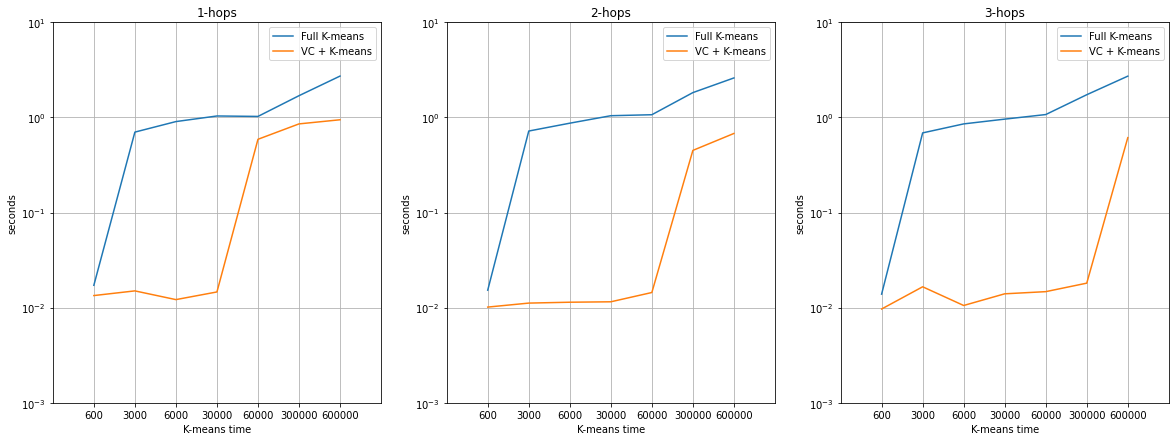

In [32]:
def my_plot(x, y, title="", label=""):
    plt.plot(np.arange(len(x))+1, y, label=label)
    plt.xticks(np.arange(len(x))+1, x*6)
    plt.yticks(np.arange(-3,2), ("$10^{%i}$" % i for i in np.arange(-3,2)))
    plt.xlabel("K-means time")
    plt.ylabel("seconds")
    plt.xlim(0, len(x)+1)
    plt.title(title)
    plt.grid()

plt.figure(figsize=(20,7))
for hop in [1,2,3]:
    results_hop = [
        results[(6,i,10,hop)]
        for i in n_samples_per_cluster
    ]

    plt.subplot(1,3,hop)
    my_plot(
        np.array(n_samples_per_cluster), 
        [
            np.log(r['time_kmeans'])/np.log(10)
            for r in results_hop
        ],
        title=f"{hop}-hops",
        label="Full K-means"
    )
    
    my_plot(
        np.array(n_samples_per_cluster), 
        [
            np.log(r['time_kmeans_vc'])/np.log(10)
            for r in results_hop
        ],
        title=f"{hop}-hops",
        label="VC + K-means"
    )
    plt.grid()
    plt.legend()

In [33]:
sizes = np.array([100, 1000, 10000, 50000])

for hop in [1,2,3]:
    results_hop = [
        results[(6,i,10,hop)]
        for i in n_samples_per_cluster
    ]
    for result in results_hop:
        print(
            "size:",
            result['n_samples'],
            "-- n_hops:",
            hop,
            "-- %reduction:", 
            100 - result['n_anchors']/result['n_samples']*100
        )

size: 600 -- n_hops: 1 -- %reduction: 97.5
size: 3000 -- n_hops: 1 -- %reduction: 97.83333333333333
size: 6000 -- n_hops: 1 -- %reduction: 97.7
size: 30000 -- n_hops: 1 -- %reduction: 97.69
size: 60000 -- n_hops: 1 -- %reduction: 97.665
size: 300000 -- n_hops: 1 -- %reduction: 97.57866666666666
size: 600000 -- n_hops: 1 -- %reduction: 97.55433333333333
size: 600 -- n_hops: 2 -- %reduction: 99.0
size: 3000 -- n_hops: 2 -- %reduction: 99.8
size: 6000 -- n_hops: 2 -- %reduction: 99.83333333333333
size: 30000 -- n_hops: 2 -- %reduction: 99.66
size: 60000 -- n_hops: 2 -- %reduction: 99.67
size: 300000 -- n_hops: 2 -- %reduction: 99.59866666666667
size: 600000 -- n_hops: 2 -- %reduction: 99.59533333333333
size: 600 -- n_hops: 3 -- %reduction: 99.0
size: 3000 -- n_hops: 3 -- %reduction: 99.8
size: 6000 -- n_hops: 3 -- %reduction: 99.9
size: 30000 -- n_hops: 3 -- %reduction: 99.85333333333334
size: 60000 -- n_hops: 3 -- %reduction: 99.85
size: 300000 -- n_hops: 3 -- %reduction: 99.777333333333